### HITO: On the use of Matched filter and Hypothesis testing
As It is been explaned in the report and other notebooks, a matched filter is a linear filter whose purpose is to maximize the Signal to Noise Ratio of an observed data $x(t)$ by find an optimal impulse response filter $h(-t)$ which we call the Template Waveform. All the formulation of this Matched filter is explained in the Report. But basically we calculate:

$$ SNR_{t_0} = \frac{(x|h)_{t_0}}{\sqrt{(h|h)_{t_0=0}}} = \frac{\int_{-\infty}^{\infty} \frac{\tilde{x}(f)\tilde{h}^{*}(f)}{S_n(f)} e^{2\pi i f t_0} df}{\sqrt{\int_{-\infty}^{\infty} \frac{|\tilde{h}(f)|^{2}}{S_n(f)} df}}$$

Where tilde denotes the fourier transform of the variable, $S_n(f)$ is the PSD of the detector noise and $t_0$ is the time-shift at which the template match the best with the observed data.

Also we implement an Hypothesis test in order to know when a dection is good under a given threshold. You can see on the report this entire formulation. But the main idea is, under a determined threshold $\eta$, we use the likelihood ratio $\Lambda$ to decide which hypothesis is more correct:

$$ln[\Lambda\lbrace(x|h)\rbrace] =  \lbrace (x|h) - \frac{1}{2}(h|h) \rbrace \begin{array}{c}H_1 \\ > \\ < \\ H_0 \end{array} ln\left[ \frac{p_0}{p_1} \right] = ln[\eta]$$

which is writen more clearly as:

$$ (x|h)\begin{array}{c}H_1 \\ > \\ < \\ H_0 \end{array} ln[\eta] + \frac{1}{2}(h|h) = \eta'$$

Here the threshold $\eta'$ depend on the a priori probabilities $P(H_0)$ and $P(H_1)$ and the value of the optimal linear filter $(h|h)_0$. Then we just need to know if our detected linear filter $(x|h)$ satisfied the threshold cut or not, this is writen in terms of SNR as follow:


$$ SNR \begin{array}{c}H_1 \\ > \\ < \\ H_0 \end{array} \frac{ln[\eta]}{\sqrt{(h|h)_0}} + \frac{1}{2}\sqrt{(h|h)_0} = \eta'$$

## Experiments
Here we are going to show how the implementation of Matched Filter using Signal Decomposition by linear regresors to do the Fourier Transfrom works. For that we are going to creat some simulated data composed of sinusoidal signals and gaussian noise, then apply the Matched filter and check the results by the Hypothesis test.


In [1]:
# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

# in order to use custom modules in parent path
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
#from mfilter.hypothesistest.probabilities import HypothesisTesting
%matplotlib inline
plt.style.use('seaborn')

#### Simulating data

[2.0, 4.0, 6.0]


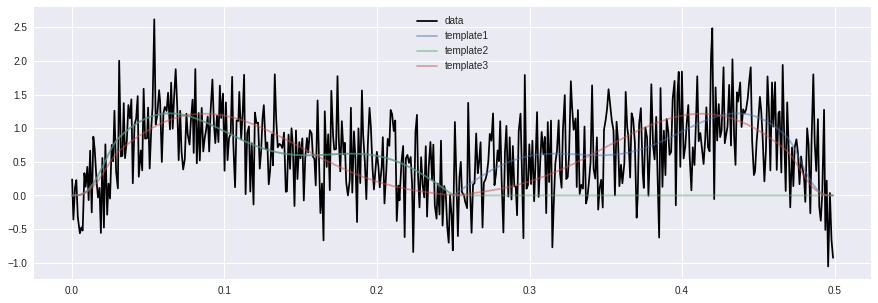

In [2]:

def gen_data(n_samples, underlying_delta=50, min_freq=None):
    min_freq = 1 / (n_samples * underlying_delta) if min_freq is None else min_freq
    freq = [min_freq, min_freq * 2, min_freq * 3]
    weights=[1, 0.3, 0.3]
    config="slight"
    noise_level=0.5
    simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=noise_level,
                               dwindow="tukey", underlying_delta=underlying_delta)

    # get the times
    times = simulated.get_times(configuration=config)

    # next generate 2 templates of different number of peaks and position of start
    pos_start_t1 = 0
    pos_start_t2 = 0
    temp1 = simulated.get_data(pos_start_peaks=pos_start_t1, n_peaks=1, with_noise=False,
                              configuration=config)
    temp1 = abs(temp1)
    temp2 = simulated.get_data(pos_start_peaks=pos_start_t2, n_peaks=0.5, with_noise=False,
                              configuration=config)
    temp2 = abs(temp2)
    # and generate the noise
    noise = simulated.get_noise(None)

    # finally we create another template with different form
    freq2 = [min_freq, min_freq * 2]
    weights2=[1, 0.4]
    simulated2 = SimulateSignal(n_samples, freq2, weights=weights2,
                               dwindow="tukey", underlying_delta=underlying_delta)
    pos_start_t3 = pos_start_t1
    temp3 = simulated2.get_data(pos_start_peaks=pos_start_t3, n_peaks=1, with_noise=False,
                              configuration=config)
    temp3 = abs(temp3)
    # and create the data
    data = noise + temp1
    # set all as TimeSeries, in the future SimulateData class should return timeseries by his own
    times = TimesSamples(initial_array=times)
    temp1 = TimeSeries(temp1, times=times)
    temp2 = TimeSeries(temp2, times=times)
    temp3 = TimeSeries(temp3, times=times)
    data = TimeSeries(data, times=times)
    noise = TimeSeries(noise, times=times)

    return times, data, noise, temp1, temp2, temp3, freq

times, data, noise, temp1, temp2, temp3, freq = gen_data(500, underlying_delta=0.001)
print(freq)
# put all in a plot
plt.figure(figsize=(15, 5))
plt.plot(times, data, 'k', label="data")
plt.plot(times, temp1, label="template1", alpha=0.5)
plt.plot(times, temp2, label="template2", alpha=0.5)
plt.plot(times, temp3, label="template3", alpha=0.5)
plt.legend()

#### Implement the Matched Filter methods
For the implementation with linear regresors we need to set the regresor, there are 3 options so far now:
* Ridge Regression
* LASSO
* Elastic Net

Since we are doing overfiting we dont care too much about wich regressor is the best, and here i just gona use the Ride Regressor.
These regressor demand the computation of a dictionary, in this case the dictionary is the Fourier Matrix for which we have implemented a class too.

In [3]:
# first define the sampling grid
samples_per_peak = 10


freqs = FrequencySamples(input_time=times,
                        minimum_frequency=-max(freq)*2,
                        maximum_frequency=max(freq)*2,
                        samples_per_peak=samples_per_peak)

F = Dictionary(times, freqs)
reg = RidgeRegression(alpha=1000, phi=F)
# reg = ElasticNetRegression(alpha=0.01, l1_ratio=0.7, phi=F)
# reg = LassoRegression(alpha=0.001, phi=F)
print(F.shape(splited=False))

(500, 121)


We also need to compute a PSD, luckly we have implemented lomb-scargle on FrequencySamples object.
In the future we expect to implement a Lomb-Welch average PSD for estimate PSD of noise using input data

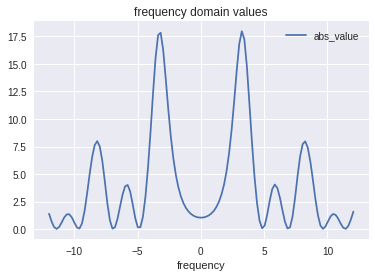

488.49048635114036


In [4]:
psd = freqs.lomb_scargle(times, data, norm="psd")
psd.plot(by_components=False)
print(psd.sum())
psd = None

Also we will calculate the FrequencySeries previously for all templates and data

(0, 8.0)

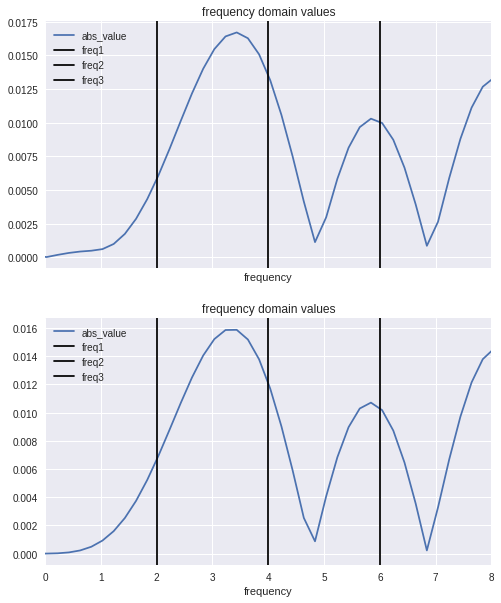

In [5]:
stilde = make_frequency_series(data, frequency_grid=freqs, reg=reg)
ntilde = make_frequency_series(noise, frequency_grid=freqs, reg=reg)
htilde1 = make_frequency_series(temp1, frequency_grid=freqs, reg=reg)
htilde2 = make_frequency_series(temp2, frequency_grid=freqs, reg=reg)
htilde3 = make_frequency_series(temp3, frequency_grid=freqs, reg=reg)

h1_norm = sigmasq(htilde1, psd=psd)
h2_norm = sigmasq(htilde2, psd=psd)
h3_norm = sigmasq(htilde3, psd=psd)
s_norm = sigmasq(stilde, psd=psd)
n_norm = sigmasq(ntilde, psd=psd)
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
stilde.plot(axis=ax1, by_components=False, _show=False)
ax1.axvline(freq[0], color="black", linestyle='solid', label="freq1")
ax1.axvline(freq[1], color="black", linestyle='solid', label="freq2")
ax1.axvline(freq[2], color="black", linestyle='solid', label="freq3")
ax1.legend()

htilde1.plot(axis=ax2, by_components=False, _show=False)
ax2.axvline(freq[0], color="black", linestyle='solid', label="freq1")
ax2.axvline(freq[1], color="black", linestyle='solid', label="freq2")
ax2.axvline(freq[2], color="black", linestyle='solid', label="freq3")
ax2.legend()
ax2.set_xlim([0, freq[2] + freq[0]])

0.00019572383793202322


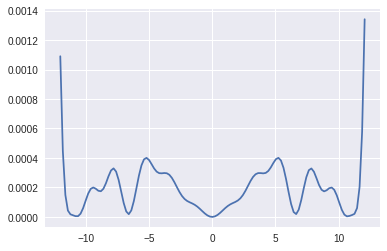

In [6]:
plt.plot(freqs, abs(ntilde)**2 * F.shape(splited=False)[1])
print((abs(ntilde)**2).sum())

246
0.16107990100601716 0.46597229582237537 0.259046046711435


(array([12., 20., 30., 32.,  4.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.29024704, -0.17193853, -0.05363002,  0.06467849,  0.182987  ,
         0.30129551,  0.41960402,  0.53791253,  0.65622104,  0.77452955,
         0.89283806]),
 <a list of 10 Patch objects>)

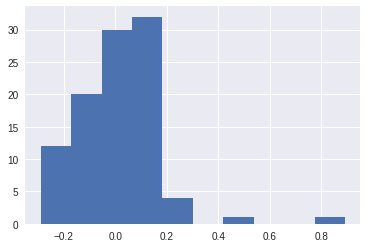

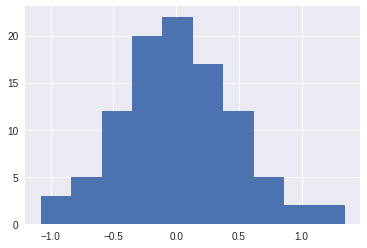

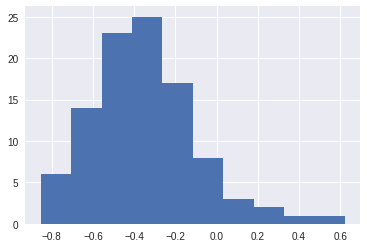

In [7]:
# t_shifted = times - times[len(data)//2]
# noise_psd = freqs.lomb_scargle(times, noise, norm="psd").value
# noise_psd = abs(stilde)**2
# noise_psd = np.ones(len(freqs)) * np.median(noise_psd)
# white_filter = FrequencySeries(1/np.sqrt(noise_psd * len(freqs)), frequency_grid=freqs, epoch=data.epoch)
# white_filter.plot(by_components=False)
# print((noise_psd * (white_filter.value**2)).sum())
# lft1, lff1 = linear_filter(white_filter, noise, psd=psd, frequency_grid=freqs, reg=reg)
# lft1.plot()
# noise.plot()

def checking(n):
    underlying_delta=1
    n_samples = 50
    min_freq = 1 / (n_samples * underlying_delta)
    freq = [min_freq, min_freq * 2, min_freq * 3]
    weights=[1, 0.3, 0.3]
    config="slight"
    noise_level=0.5
    simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=noise_level,
                               dwindow="tukey", underlying_delta=underlying_delta)
    # get the times
    times = simulated.get_times(configuration=config)
    times = TimesSamples(initial_array=times)
    temp1 = simulated.get_data(pos_start_peaks=0, n_peaks=1, with_noise=False,
                              configuration=config)
    temp1 = abs(temp1)
    temp1 = TimeSeries(temp1, times=times)
    
    temp2 = simulated.get_data(pos_start_peaks=20, n_peaks=1, with_noise=False,
                              configuration=config)
    temp2 = abs(temp2)
    temp2 = TimeSeries(temp2, times=times)
    
    samples_per_peak = 5
    freqs = FrequencySamples(input_time=times, minimum_frequency=-1 / (2 * underlying_delta),
                                 maximum_frequency=1 / (2 * underlying_delta),
                                 samples_per_peak=samples_per_peak)
    print(len(freqs))
    F = Dictionary(times, freqs)
    reg = RidgeRegression(alpha=1000, phi=F)
    r = []
    r0 = []
    s = []
    for i in range(n):
        noise = TimeSeries(simulated.get_noise(None), times=times)
        data = TimeSeries(temp1 + noise, times=times)
        ntilde = noise.to_frequencyseries(frequency_grid=freqs, reg=reg)
        stilde = data.to_frequencyseries(frequency_grid=freqs, reg=reg)
        r0.append(noise[0])
        noise_psd = freqs.lomb_scargle(times, noise, norm="psd").value
        white_filter = FrequencySeries(1/np.sqrt(noise_psd), frequency_grid=freqs, epoch=data.epoch)
#         lft1, lff1 = linear_filter(white_filter, noise, psd=None, frequency_grid=freqs, reg=reg)
#         r.append(lft1[0])
        h_filter = temp2.to_frequencyseries(frequency_grid=freqs, reg=reg)
    
        n_norm = (ntilde * ntilde.conj() * white_filter.value**2).sum()
        s_norm = (stilde * stilde.conj() * white_filter.value**2).sum()
        h_norm = (h_filter * h_filter.conj() * white_filter.value**2).sum()
        
        fered_noise = (ntilde* h_filter.conj() * white_filter.value**2).sum()
        fered_data = (stilde * h_filter.conj() * white_filter.value**2).sum()
        r.append(fered_noise.real / np.sqrt(n_norm.real) / np.sqrt(h_norm.real))
        s.append(fered_data.real / np.sqrt(s_norm.real) / np.sqrt(h_norm.real))
    return r0, r, s

r0, r, s = checking(100)
plt.figure()
aa = plt.hist(r)
plt.figure()
_ = plt.hist(r0)
plt.figure()
_ = plt.hist(s)
print(np.std(r), np.std(r0), np.std(s))
aa

0.23322685712017252 0.1621533974371066 0.2746332413117791 0.02200445841169884
0.2905251083019416 0.1001073479522624 0.3092008555795771 0.02200445841169884
0.5232330136135317
1.6175523796034976e-06
2.1198145644536805


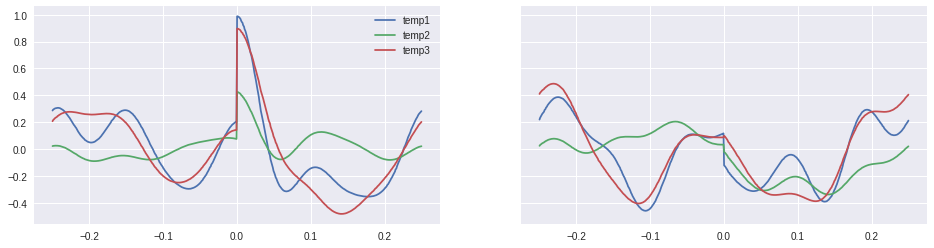

In [9]:
t_shifted = times - times[len(data)//2]

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
unit_e = False
snr1_data = matched_filter(htilde1, stilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
snr1_noise = matched_filter(htilde1, ntilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
ax1.plot(t_shifted, np.roll(snr1_data, len(snr1_data)//2), label="temp1")
ax2.plot(t_shifted, np.roll(snr1_noise, len(snr1_noise)//2))

snr2_data = matched_filter(htilde2, stilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
snr2_noise = matched_filter(htilde2, ntilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
ax1.plot(t_shifted, np.roll(snr2_data, len(snr2_data)//2), label="temp2")
ax2.plot(t_shifted, np.roll(snr2_noise, len(snr2_noise)//2))

snr3_data = matched_filter(htilde3, stilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
snr3_noise = matched_filter(htilde3, ntilde, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
ax1.plot(t_shifted, np.roll(snr3_data, len(snr3_data)//2), label="temp3")
ax2.plot(t_shifted, np.roll(snr3_noise, len(snr3_noise)//2))
ax1.legend()
test_snr1_noise = matched_filter(htilde1, ntilde, h_norm=1, psd=psd, reg=reg, times=times, unitary_energy=unit_e)
print(np.std(snr1_noise), np.std(snr2_noise), np.std(snr3_noise), np.std(test_snr1_noise))
print(np.std(snr1_data), np.std(snr2_data), np.std(snr3_data), np.std(test_snr1_noise))
print(np.std(noise))
print(np.mean(abs(ntilde)**2))
print(0.2 / np.sqrt(h1_norm))

In [10]:
max_snr, idx_max = match(htilde1, stilde, reg=reg, v1_norm=h1_norm, v2_norm=None, psd=psd, times=times)
opt_snr, idx_opt_max = match(htilde1, htilde1, reg=reg, v1_norm=h1_norm, v2_norm=None, psd=psd, times=times)
noise_snr, idx_noise_max = match(htilde1, ntilde, reg=reg, v1_norm=h1_norm, v2_norm=None, psd=psd, times=times)
print(max_snr, opt_snr, noise_snr, "idx is: ", idx_max)
max_snr, idx_max = match(htilde2, stilde, reg=reg, v1_norm=h2_norm, v2_norm=None, psd=psd, times=times)
opt_snr, idx_opt_max = match(htilde2, htilde2, reg=reg, v1_norm=h2_norm, v2_norm=None, psd=psd, times=times)
noise_snr, idx_noise_max = match(htilde2, ntilde, reg=reg, v1_norm=h2_norm, v2_norm=None, psd=psd, times=times)
print(max_snr, opt_snr, noise_snr, "idx is: ", idx_max)
max_snr, idx_max = match(htilde3, stilde, reg=reg, v1_norm=h3_norm, v2_norm=None, psd=psd, times=times)
opt_snr, idx_opt_max = match(htilde3, htilde3, reg=reg, v1_norm=h3_norm, v2_norm=None, psd=psd, times=times)
noise_snr, idx_noise_max = match(htilde3, ntilde, reg=reg, v1_norm=h3_norm, v2_norm=None, psd=psd, times=times)
print(max_snr, opt_snr, noise_snr, "idx is: ", idx_max)

0.9887863354498494 0.9999894658816157 0.45945956246945385 idx is:  0
0.4254319670345991 0.9999964213228033 0.3380740904852569 idx is:  0
0.8972312274553701 0.9999946774470285 0.4868799215809474 idx is:  0


Here we would like to know how the SNR for only noise distribute, under theory we guess that distribut as a Gaussian and we expect a distribution of $N(0,1)$, this is suposes to be independent of the 

In [ ]:
def testing(n):
    v1 = []
    v2 = []
    v3 = []
    v4 = []
    plt.figure()
    underlying_delta=0.001
    n_samples = 100
    min_freq = 1 / (n_samples * underlying_delta)
    freq = [min_freq, min_freq * 2, min_freq * 3]
    weights=[1, 0.3, 0.3]
    config="slight"
    noise_level=0.5
    simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=noise_level,
                               dwindow="tukey", underlying_delta=underlying_delta)
    # get the times
    times = simulated.get_times(configuration=config)

    # next generate 2 templates of different number of peaks and position of start
    pos_start_t1 = 0
    pos_start_t2 = 0
    temp1 = simulated.get_data(pos_start_peaks=pos_start_t1, n_peaks=1, with_noise=False,
                              configuration=config)
    temp1 = abs(temp1)
    times = TimesSamples(initial_array=times)
    temp1 = TimeSeries(temp1, times=times)
    for i in range(n):
        noise = simulated.get_noise(None)
        noise = TimeSeries(noise, times=times)
        # first define the sampling grid
        samples_per_peak = 10
        freqs = FrequencySamples(input_time=times, minimum_frequency=-max(freq)*2,
                                 maximum_frequency=max(freq)*2,
                                 samples_per_peak=samples_per_peak)

        F = Dictionary(times, freqs)
        reg = RidgeRegression(alpha=1000, phi=F)
        psd = freqs.lomb_scargle(times, noise, norm="psd")
        ntilde = make_frequency_series(noise, frequency_grid=freqs, reg=reg)
        htilde1 = make_frequency_series(temp1, frequency_grid=freqs, reg=reg)
        snr_noise = matched_filter(htilde1, ntilde, psd=psd, reg=reg, times=times, unitary_energy=False)
        plt.plot(times, snr_noise, 'k', alpha=0.3)
        v1.append(snr_noise[0])
        v2.append(snr_noise[50])
        v3.append(snr_noise[30])
        v4.append(snr_noise[99])
        
    return v1, v2, v3, v4

v1, v2, v3, v4 = testing(100)
        
        
    

In [ ]:
print(np.std(v1), np.std(v2), np.std(v3), np.std(v4))
print(np.mean(v1), np.mean(v2), np.mean(v3), np.mean(v4))

#### Hypothesis Testing
Using results of the SNR for every Template we can estimate the probability of that SNR representing a real signal,
here we need to give a fixed probability of false alarm or probability of detection in order to define the threshold, or you could give directly a threshold

In [ ]:
false_alarm = 0.1
p_detect = None
def set_threshold_params(h, false_alarm=None, p_detect=None, name_template="h"):
    test = HypothesisTesting(h.real, false_alarm=false_alarm, p_detect=p_detect)
    test.set_threshold()
    print("threshold value for {} is: ".format(name_template), round(test.threshold, 3), " with... \n:::: false alarm of: ", 
          round(test.false_alarm(), 3), " and prob. of detect: ", round(test.p_detection(), 3))
    return test


h1_test = set_threshold_params(h1.real, false_alarm=false_alarm, p_detect=None, name_template="h1")
h2_test = set_threshold_params(h2.real, false_alarm=false_alarm, p_detect=None, name_template="h2")
h3_test = set_threshold_params(h3.real, false_alarm=false_alarm, p_detect=None, name_template="h3")

def choose(snr_max, hyp_test, name_snr="snr", name_template="h"):
    h_true = hyp_test.decide(snr_max)
    print("for SNR of {} under template {} ge choose hypothesis H{} as correct and...".format(name_snr, 
                                                                                              name_template, 
                                                                                              h_true),
         "\n::::: false alarm for SNR is: ", hyp_test.false_alarm(threshold=snr_max), 
         " and prob. of detect is: ", hyp_test.p_detection(threshold=snr_max))
    return

def plot_hyp(loc, scale, snr_max):
    norm1 = sp.stats.norm(loc=0, scale=scale)
    norm2 = sp.stats.norm(loc=loc, scale=scale)
    vals = np.linspace(0 - 2 * scale , mu + 2 * scale, 100)

print("\n-------------------\n")
choose(max(snr1.data), h1_test, name_snr="snr1", name_template="h1")
choose(max(snr1_noise.data), h1_test, name_snr="snr1_noise", name_template="h1")
print(" ")
choose(max(snr2.data), h2_test, name_snr="snr2", name_template="h2")
choose(max(snr2_noise.data), h2_test, name_snr="snr2_noise", name_template="h2")
print(" ")
choose(max(snr3.data), h3_test, name_snr="snr3", name_template="h3")
choose(max(snr3_noise.data), h3_test, name_snr="snr3_noise", name_template="h3")

In [ ]:
norm1 = sp.stats.norm(loc=0, scale=1)
norm2 = sp.stats.norm(loc=np.sqrt(h1.real), scale=1)
vals = np.linspace(-4, 4 + np.sqrt(h1.real), 200)
h_0 = norm1.pdf(vals)
h_1 = norm2.pdf(vals)
plt.figure(figsize=(15, 4))
plt.plot(vals, h_0, 'b', label="H0")
plt.plot(vals, h_1, 'g', label="H1")
plt.fill_between(vals, 0, h_0, where=vals > h1_test.threshold, facecolor="blue")
plt.axvline(h1_test.threshold, color='k', linestyle='solid', label="threshold")
plt.axvline(np.max(snr1.data), color='r', label="SNR detection")
plt.legend()